### Black-Scholes Option Pricing and Implied Volatility using Newton-Raphson Method

In this code, we aim to compute the implied volatility using the Black-Scholes formula and its derivative (Vega) through the Newton-Raphson and bisection method.

### Volatility Smile with Convexity

The **volatility smile** is a graphical representation of implied volatility as a function of strike price. In most markets, implied volatility tends to vary with the strike price, often forming a "smile" shape. To model this, we can adjust the volatility using a function that incorporates skew and convexity effects. 

- **Normal Distribution ($N(x)$)**
- **Probability Density Function ($PDF(x)$):**
- **Black-Scholes Formula ($bs$):**
- **Vega ($vega$):**

are as they have been described in 1.1 and 1.2

In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def N(x):
	return (1.0 + np.sign(x) * np.sqrt(1.0 - np.exp(-x**2 * (2.0 / np.pi) / (1.0 + 0.2316419 * abs(x))))) / 2.0

def PDF(x):
	return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def bs(type, s, k, r, vol, T):
	d1 = (np.log(s/k) + (r+(vol**2)/2) * T)/(vol*(np.sqrt(T)))
	d2 = d1 - vol * np.sqrt(T)

	return s*N(d1)-k*np.exp(-r*T)*N(d2) if type == "call" else k*np.exp(-r*T)*N(-d2)-s*N(-d1)

def vega( s, k, r, vol, T):
	d1 = (np.log(s/k) + (r+(vol**2)/2) * T)/(vol*(np.sqrt(T)))
	return (s*np.sqrt(T)*PDF(d1))

s = 100
k = 105
r = 0.04
T = 1
vol = 0.2
market_price = 5

### Implied Volatility and Numerical Methods: Newton-Raphson and Bisection

In the context of option pricing, **implied volatility** refers to the volatility value that, when input into the Black-Scholes model, yields an option price that matches the observed market price. Since the Black-Scholes equation doesn't have an explicit solution for volatility, numerical methods are used to estimate it. Two such methods are the **Newton-Raphson method** and the **Bisection method**.

#### Newton-Raphson Method for Implied Volatility:
The **Newton-Raphson method** is an iterative approach used to find the root of a function. In this case, the goal is to find the volatility that makes the Black-Scholes price match the market price. Mathematically, the iteration formula is:

$$
vol_{new} = vol_{old} - \frac{f(vol)}{f'(vol)}
$$

The method converges quickly when the initial guess for volatility is close to the actual value. However, it can diverge or become unstable if the initial guess is poor or if the function is not well-behaved.

In [2]:
def implied_volatility_newton(type, s, k, r, T, market_price, tol=1e-5, max_iter=100):
	vol = 0.2  # initial guess for volatility
	for i in range(max_iter):
		price = bs(type, s, k, r, vol, T)
		v = vega(s, k, r, vol, T)
		price_diff = price - market_price
		
		if abs(price_diff) < tol:
			return vol
		
		vol = vol - price_diff / v  # Newton-Raphson update
	return vol

#### Bisection Method for Implied Volatility:
The **Bisection method** is a more robust but slower iterative method for finding roots. It works by repeatedly halving the interval between two bounds where the root is known to lie. The process is continued until the desired accuracy is achieved.
   $$
   mid\_vol = \frac{low + high}{2}
   $$

This method guarantees convergence because the solution is always bracketed between the bounds, though it is slower than Newton-Raphson.

In [3]:
def implied_volatility_bisection(type, s, k, r, T, market_price, tol=1e-5, max_iter=100):
    low, high = 0.01, 3  # initial bounds for volatility
    for i in range(max_iter):
        mid_vol = (low + high) / 2
        price = bs(type, s, k, r, mid_vol, T)
        if abs(price - market_price) < tol:
            return mid_vol
        elif price > market_price:
            high = mid_vol
        else:
            low = mid_vol
    return mid_vol

#### Comparing Newton-Raphson and Bisection:
- **Newton-Raphson**: Faster convergence but sensitive to the initial guess and function behavior.
- **Bisection**: Slower but always converges if the root is within the interval, making it more robust for complicated functions.

The goal of both methods is to find the volatility that equates the **Black-Scholes price** with the **market price** of the option.

In [4]:
implied_vol_NR = implied_volatility_newton("call", s, k, r, T, market_price)
implied_vol_BI = implied_volatility_bisection("call", s, k, r, T, market_price)
print(f"Implied Volatility (Newton-Raphson): {implied_vol_NR:.6f}", f"\nImplied Volatility (Bisection): {implied_vol_BI:.6f}")

Implied Volatility (Newton-Raphson): 0.137597 
Implied Volatility (Bisection): 0.137597




#### Volatility Smile Function:
The function `volatility_smile_with_convexity` models the implied volatility with three components:
- **ATM Volatility ($atm\_vol$)**: The at-the-money (ATM) volatility is the volatility level when the strike price equals the spot price.
- **Skew ($skew$)**: The skew reflects the tendency of implied volatility to increase or decrease as we move away from the ATM strike price. The skew adds a linear effect based on the absolute difference between the strike and spot prices.
- **Convexity ($convexity$)**: This introduces a quadratic term that adjusts the curvature of the smile. Convexity adds a second-order effect to better capture the smile or frown shape in implied volatility.

The purpose of this function is to simulate realistic market behavior for at-the-money (ATM) and in-the-money (ITM) option prices. We do this by artificially and deliberately increasing the volatility, allowing the Black-Scholes model to generate a suitable set of market prices. These prices are then used to recalculate the implied volatility. While we could have generated an artificial set of market prices directly, doing so would risk introducing abnormal or unrealistic data.


#### Steps in the Code:
1. **Calculate Market Prices**: The function `volatility_smile_with_convexity` is used to estimate the implied volatility for different strike prices based on the skew and convexity. Using these volatilities, the **Black-Scholes price** of a call option is computed for each strike price.
   
2. **Calculate Implied Volatilities**: The implied volatilities are then calculated using the **Bisection method**. This method estimates the implied volatility by matching the calculated Black-Scholes price with the market price for each strike.

3. **Plot the Volatility Smile**: Finally, the implied volatilities are plotted against the corresponding strike prices, showing how the implied volatility varies as a function of strike.

This results in a **volatility smile** that reflects both the skew and convexity effects commonly observed in real-world options markets.


In [5]:
# Volatility smile function with convexity
def volatility_smile_with_convexity(strike, atm_vol=0.2, skew=0.2, convexity=5):
    relative_strike = (strike - s) / s  # Normalize strike relative to spot price
    return atm_vol + skew * abs(relative_strike) + convexity * (relative_strike ** 2)

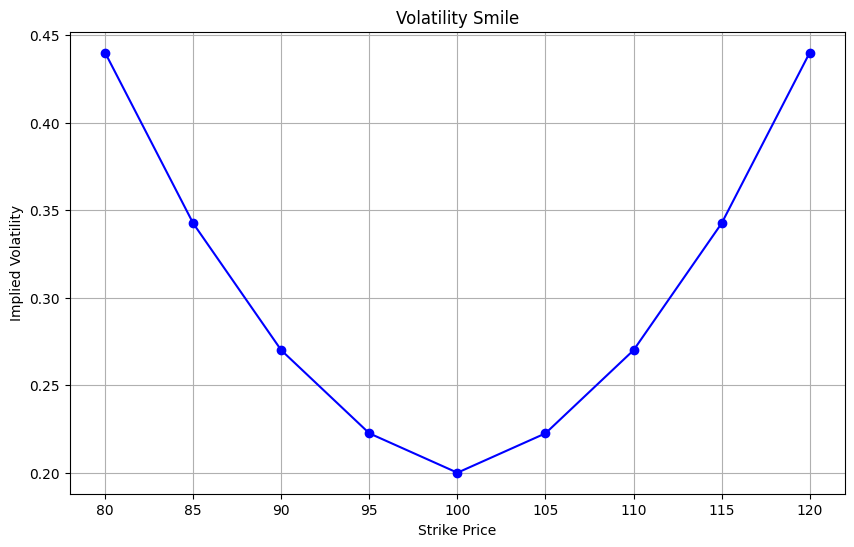

In [6]:
strikes = np.linspace(80, 120, 9)  # Range of strike prices
market_prices = [bs("call", s, k, r, volatility_smile_with_convexity(k), T) for k in strikes]

# Calculate implied volatilities for each strike
implied_vols = [implied_volatility_bisection("call", s, k, r, T, price) for k, price in zip(strikes, market_prices)]

# Plot the volatility smile
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, marker='o', color='blue')
plt.title('Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()
